# Installations

In [ ]:
!pip install CocoDataset==0.1.2
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!git clone https://github.com/tatwan/image-captioning-pytorch.git
!pip install pycocotools

--2024-05-24 07:26:43--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.96.193, 3.5.28.156, 3.5.0.103, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.96.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  49.9MB/s    in 5.4s    

2024-05-24 07:26:49 (44.8 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

Archive:  /content/annotations_trainval2014.zip
  inflating: annotations/instances_train2014.json  
  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  
Cloning into 'image-captioning-py

#dataset download from kaggle

In [ ]:
!pip install kaggle

import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content'

!kaggle datasets download -d jeffaudi/coco-2014-dataset-for-yolov3

Dataset URL: https://www.kaggle.com/datasets/jeffaudi/coco-2014-dataset-for-yolov3
License(s): Attribution 4.0 International (CC BY 4.0)
100% 25.0G/25.0G [05:23<00:00, 62.6MB/s]
100% 25.0G/25.0G [05:23<00:00, 83.0MB/s]


In [ ]:
import zipfile
file_path = "/content/coco-2014-dataset-for-yolov3.zip"

with zipfile.ZipFile(file_path, 'r') as zip_ref:
  zip_ref.extractall("/content")

#importing libraries

In [4]:

import torch
import torch.nn as nn
import torchvision.models as models
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter
import os
import sys
import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json
from torchvision import transforms
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:

sys.path.append('/opt/cocoapi/PythonAPI')

In [6]:
# initialize COCO API for instance annotations
dataDir = '/opt/cocoapi'
dataType = 'val2014'
path_ins = "/content/annotations/instances_val2014.json"
# instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
instances_annFile = os.path.join(path_ins)
coco = COCO(instances_annFile)


path_cap = "/content/annotations/captions_val2014.json"
# initialize COCO API for caption annotations
# captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
captions_annFile = os.path.join(path_cap)
coco_caps = COCO(captions_annFile)

# get image ids
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=11.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!


In [7]:
list(coco.anns.values())[0]

{'segmentation': [[239.97,
   260.24,
   222.04,
   270.49,
   199.84,
   253.41,
   213.5,
   227.79,
   259.62,
   200.46,
   274.13,
   202.17,
   277.55,
   210.71,
   249.37,
   253.41,
   237.41,
   264.51,
   242.54,
   261.95,
   228.87,
   271.34]],
 'area': 2765.1486500000005,
 'iscrowd': 0,
 'image_id': 558840,
 'bbox': [199.84, 200.46, 77.71, 70.88],
 'category_id': 58,
 'id': 156}

http://images.cocodataset.org/val2014/COCO_val2014_000000168234.jpg


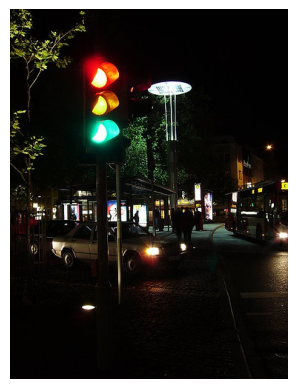

A car and a bus are near a street light at night.
A traffic control light has all three lights on at once
a traffic light with red yellow and green lit up
a traffic light with all of its light turned on 
bus and a car stopped at a traffic light


In [8]:
# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

# creating vocabulary from training data for the captions


In [9]:

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='/content/image-captioning-pytorch/vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)

    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

# get loader function for data loader->

In [41]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary.
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """

    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        # img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        # annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
        img_folder = os.path.join('/content/coco2014/images/train2014') #added by renu
        annotations_file = os.path.join('/content/annotations/captions_train2014.json') # added by renu
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join('/content/coco2014/images/test2014')
        # annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')
        annotations_file = os.path.join('/content/_test.coco.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset,
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader


# COCO Dataset

In [ ]:
class CoCoDataset(data.Dataset):
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word,
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]

    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [11]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # pretrained model resnet50
        resnet = models.resnet50(pretrained=True)

        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # replace the classifier with a fully connected embedding layer
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.word_embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.lstm = nn.LSTM(self.embed_size,
                            self.hidden_size,
                            self.num_layers,
                            batch_first=True)

        self.fc = nn.Linear(self.hidden_size, self.vocab_size)
#         self.hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))


    def forward(self, features, captions):

        caption_embed = self.word_embedding(captions[:, :-1])
        caption_embed = torch.cat((features.unsqueeze(dim=1), caption_embed),1)
        output, self.hidden = self.lstm(caption_embed)
#         print(output.shape)
        output = self.fc(output)
#         print(self.embed_size, self.vocab_size)
        return output

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "

        """Samples captions for given image features."""
        output = []
        (h, c) = (torch.randn(self.num_layers, 1, self.hidden_size).to(inputs.device), torch.randn(self.num_layers, 1, self.hidden_size).to(inputs.device))
        for i in range(max_len):
            x, (h, c) = self.lstm(inputs, (h, c))
            x = self.fc(x)
            x = x.squeeze(1)
            predict = x.argmax(dim=1)
            if predict.item() == 1:
                break
            output.append(predict.item())
            inputs = self.word_embedding(predict.unsqueeze(0))
        return output

In [12]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
!pip install nltk
import nltk
nltk.download('punkt')
# from data_loader import get_loader
# from torchvision import transforms
from pycocotools.coco import COCO

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [13]:
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=1.08s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=1.30s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:27<00:00, 4747.15it/s]


In [14]:
sample_caption = 'A person doing a trick on a rail while riding a skateboard.'
sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

sample_caption = []

start_word = data_loader.dataset.vocab.start_word
print('Special start word:', start_word)
sample_caption.append(data_loader.dataset.vocab(start_word))
print(sample_caption)

sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)

['a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.']
Special start word: <start>
[0]
[0, 3, 98, 754, 3, 396, 39, 3, 1010, 207, 139, 3, 753, 18]


In [15]:
end_word = data_loader.dataset.vocab.end_word
print('Special end word:', end_word)

sample_caption.append(data_loader.dataset.vocab(end_word))
print(sample_caption)

sample_caption = torch.Tensor(sample_caption).long()
print(sample_caption)

# Preview the word2idx dictionary.
dict(list(data_loader.dataset.vocab.word2idx.items())[:10])

# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))



Special end word: <end>
[0, 3, 98, 754, 3, 396, 39, 3, 1010, 207, 139, 3, 753, 18, 1]
tensor([   0,    3,   98,  754,    3,  396,   39,    3, 1010,  207,  139,    3,
         753,   18,    1])
Total number of tokens in vocabulary: 8852


In [ ]:
vocab_threshold = 4

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=1.20s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:16<00:00, 5382.02it/s]


In [ ]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

unk_word = data_loader.dataset.vocab.unk_word
print('Special unknown word:', unk_word)

print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))

print(data_loader.dataset.vocab('jfkafejw'))
print(data_loader.dataset.vocab('ieowoqjf'))

# Obtain the data loader (from file). Note that it runs much faster than before!
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_from_file=True)

Total number of tokens in vocabulary: 9947
Special unknown word: <unk>
All unknown words are mapped to this integer: 2
2
2
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:22<00:00, 5001.11it/s]


In [ ]:
from collections import Counter

# Tally the total number of training captions with each length.
counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    print('value: %2d --- count: %5d' % (value, count))

import numpy as np
import torch.utils.data as data

# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler


# (Optional) Uncomment the lines of code below to print the pre-processed images and captions.
# print('images:', images)
# print('captions:', captions)

value: 10 --- count: 86302
value: 11 --- count: 79971
value:  9 --- count: 71920
value: 12 --- count: 57653
value: 13 --- count: 37668
value: 14 --- count: 22342
value:  8 --- count: 20742
value: 15 --- count: 12839
value: 16 --- count:  7736
value: 17 --- count:  4845
value: 18 --- count:  3101
value: 19 --- count:  2017
value:  7 --- count:  1594
value: 20 --- count:  1453
value: 21 --- count:   997
value: 22 --- count:   683
value: 23 --- count:   534
value: 24 --- count:   384
value: 25 --- count:   277
value: 26 --- count:   214
value: 27 --- count:   160
value: 28 --- count:   114
value: 29 --- count:    87
value: 30 --- count:    58
value: 31 --- count:    49
value: 32 --- count:    44
value: 34 --- count:    40
value: 37 --- count:    32
value: 35 --- count:    31
value: 33 --- count:    30
value: 36 --- count:    26
value: 38 --- count:    18
value: 39 --- count:    18
value: 43 --- count:    16
value: 44 --- count:    16
value: 48 --- count:    12
value: 45 --- count:    11
v

In [ ]:
# # Obtain the batch.
images, captions = next(iter(data_loader))

print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 14])


In [ ]:
# Watch for any changes in model.py, and re-load it automatically.
# % load_ext autoreload
# % autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
images[0].shape

torch.Size([3, 224, 224])

In [ ]:
# Specify the dimensionality of the image embedding.
embed_size = 256

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)

# Move last batch of images (from Step 2) to GPU if CUDA is available.
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

# Check that your encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor."
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.6MB/s]


type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 256])


In [ ]:
features[0].shape

torch.Size([256])

In [ ]:
# Specify the number of features in the hidden state of the RNN decoder.
hidden_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move the decoder to GPU if CUDA is available.
decoder.to(device)

# Move last batch of captions (from Step 1) to GPU if CUDA is available
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

# Check that your decoder satisfies some requirements of the project! :D
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder output is incorrect."

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 14, 9947])


# part

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
# from data_loader import get_loader
# from model import EncoderCNN, DecoderRNN
import math


## Select appropriate values for the Python variables below.
batch_size = 10          # batch size
vocab_threshold = 4        # minimum word count threshold
vocab_from_file = True      # if True, load existing vocab file
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional)  Amend the image transform below.
transform_train = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function.
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.parameters())+list(encoder.embed.parameters())

# Define the optimizer.
optimizer = torch.optim.Adam(params,lr=0.001)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...
Done (t=2.91s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:25<00:00, 4832.36it/s]


In [ ]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time
import sys

# Assuming log_file, num_epochs, total_step, data_loader, device, decoder, encoder, criterion, vocab_size, optimizer, print_every, save_every are defined somewhere in the code above this snippet.

# Open the training log file.
f = open(log_file, 'w')
old_time = time.time()
response = requests.request("GET", "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", headers={"Metadata-Flavor":"Google"})

for epoch in range(1, num_epochs+1):
    for i_step in range(1, total_step+1):
        if time.time() - old_time > 60:
            old_time = time.time()
            try:
                requests.request("POST", "https://nebula.udacity.com/api/v1/remote/keep-alive", headers={'Authorization': "STAR " + response.text})
            except requests.RequestException as e:
                print(f"\nKeep-alive request failed: {e}")

        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()

        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler

        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)

        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()

        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)

        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))

        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))

        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()

        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()

        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)

    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()


Epoch [1/1], Step [15/41412], Loss: 5.4413, Perplexity: 230.7517
Keep-alive request failed: HTTPSConnectionPool(host='nebula.udacity.com', port=443): Max retries exceeded with url: /api/v1/remote/keep-alive (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7d2cfae178e0>: Failed to resolve 'nebula.udacity.com' ([Errno -2] Name or service not known)"))
Epoch [1/1], Step [31/41412], Loss: 4.5218, Perplexity: 92.0042
Keep-alive request failed: HTTPSConnectionPool(host='nebula.udacity.com', port=443): Max retries exceeded with url: /api/v1/remote/keep-alive (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7d2c332d9b70>: Failed to resolve 'nebula.udacity.com' ([Errno -2] Name or service not known)"))
Epoch [1/1], Step [47/41412], Loss: 4.4389, Perplexity: 84.6854
Keep-alive request failed: HTTPSConnectionPool(host='nebula.udacity.com', port=443): Max retries exceeded with url: /api/v1/remote/keep-alive (Caused by NameResolutionErro

In [50]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
# from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,
                         mode='test',
                        #  batch_size=batch_size,
                         vocab_from_file=True)

Vocabulary successfully loaded from vocab.pkl file!


In [48]:
print(data_loader)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [29]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Watch for any changes in model.py, and re-load it automatically.
# % load_ext autoreload
# % autoreload 2

import os
import torch
# from model import EncoderCNN, DecoderRNN

# Specify the saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('/content/image-captioning-pytorch/models/encoder-3.pkl'), map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(os.path.join('/content/image-captioning-pytorch/models/decoder-3.pkl'), map_location=torch.device('cpu')))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

In [ ]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list"
assert all([type(x)==int for x in output]), "Output should be a list of integers."
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

In [ ]:
def clean_sentence(output):
    cleaned_list = []
    for index in output:
        if  (index == 1) :
            continue
        cleaned_list.append(data_loader.dataset.vocab.idx2word[index])
    cleaned_list = cleaned_list[1:-1] # Discard <start> and <end>

    sentence = ' '.join(cleaned_list) # Convert list of string to
    sentence = sentence.capitalize()
    return sentence

In [ ]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output)
    print(sentence)